# Toxic Comment Classification

## Importing Libraries & Downloading Pre-requisites

In [ ]:
# need scikit-multilearn library for multi-label classification
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 6.6MB/s 


In [ ]:
#mandatory libraries
import os
import re
import numpy as np
import pandas as pd
import scipy
import string

#nltk-preprocessing
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.stem.wordnet import WordNetLemmatizer

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import joblib
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
from itertools import combinations

#multi-processing
import multiprocessing
from multiprocessing import Pool,freeze_support
from multiprocessing import Process

#multi-label 
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

#metrics
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc,roc_auc_score

#modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Tensor flow for MLP
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback

#model loading
from tensorflow.keras.models import load_model

In [ ]:
#supporting/essential downloads for NLTK library 
#to handle chuncking/stemming/stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#lets take all the stop words from both NLTK & Word Cloud libraries, along 
# with some custom words

stop_words=stopwords.words('english')
word_cloud_stp_wrds=list(STOPWORDS)
final_stop_words=list(STOPWORDS.union(set(stop_words)))
final_stop_words.extend(["mr","mrs","miss",
                        "one","two","three","four","five",
                        "six","seven","eight","nine","ten",
                        "us","also","dont","cant","any","can","along",
                        "among","during","anyone",
                         "a","b","c","d","e","f","g","h","i","j","k","l","m",
                         "n","o","p","q","r","s","t","u","v","w","x","y","z","hi","hello","hey","ok",
                         "okay","lol","rofl","hola","let","may","etc"])

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading the Saved Pre-processed Files

In [ ]:
clean_data=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_data_no_nan.csv")

In [ ]:
clean_data.shape

(159192, 7)

In [ ]:
clean_data.sample(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130557,post user talk cohesion talk,0,0,0,0,0,0
47573,currently senator oklahoma,0,0,0,0,0,0
114473,ved move follow statement poorly source likely...,0,0,0,0,0,0


## Splitting Data-Set into Train and Test (Stratify Sampling)

In [ ]:
X=clean_data['comment_text']
y=clean_data.drop(columns=['comment_text'])

In [ ]:
#reshaping the X into matrix, as the pre-requisite for iterative_train_test_split 
# X,y should be numpy ndarrays for iterative_train_test_split

X_train,y_train, X_test,y_test = iterative_train_test_split(X.values.reshape(-1,1),
                                                y.values,test_size = 0.2)

In [ ]:
#re-mapping to original shape

X_train=X_train.reshape(X_train.shape[0],)
X_test=X_test.reshape(X_test.shape[0],)

In [ ]:
print("Shape of X-Train",X_train.shape)
print("Shape of X-Test",X_test.shape)
print("Shape of y-Train",y_train.shape)
print("Shape of y-Test",y_test.shape)

Shape of X-Train (127353,)
Shape of X-Test (31839,)
Shape of y-Train (127353, 6)
Shape of y-Test (31839, 6)


## Vectorization using TF-IDF weighted Avg W2V

TF-IDF is unable to catch the scemantic meanings in a given input. so we will be using TF-IDF weighted Avg W2V for featurization with the help of Glove Model

In [ ]:
#downloading required glove files

!wget --header="Host: downloads.cs.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.2082044147.1609877841; _gid=GA1.2.481400140.1609877841" --header="Connection: keep-alive" "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip" -c -O 'glove.6B.zip'

In [ ]:
#copying to google-drive

!cp glove.6B.zip -r /content/gdrive/MyDrive/Colab\ Notebooks/Case_Study_1/

In [ ]:
#Extracting the zip file

from zipfile import ZipFile
file_name="/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/glove.6B.zip"
with ZipFile(file_name,'r') as zip_file:
  zip_file.extractall()

In [ ]:
# here we are using Glove which gives output of 300 dimensions
# loading words and their corresponding w2v representation.
 
w2v_dict = dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	vec = np.asarray(values[1:], dtype='float32')     
	w2v_dict[word] = vec
f.close()
print('Loaded %s word vectors.' % len(w2v_dict))
w2v_words =  set(w2v_dict.keys())

Loaded 400000 word vectors.


In [ ]:
# TF-IDF vectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1),stop_words=final_stop_words,use_idf=True)
vectorizer.fit(X_train)

# we are converting a dictionary with word as a key, and the idf as a value

tfidf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
#save data for future use

joblib.dump(tfidf_dict,'/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/tfidf_dict.pkl')
joblib.dump(tfidf_words,'/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/tfidf_words.pkl')
joblib.dump(w2v_dict,'/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/w2v_dict.pkl')
joblib.dump(w2v_words,'/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/w2v_words.pkl')

['/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/w2v_words.pkl']

In [ ]:
# computing tf-idf weighted word2vec for each comment.

def comp_tfidf_weighted_w2v(data,w2v_words,tfidf_words,w2v_dict,tfidf_dict):

    """function to calculate TF-IDF weighted avg W2V"""
    
    tfidf_w2v = []
    for sentence in tqdm(data):
        vector = np.zeros(300) 
        # as word vectors are of zero length
        tf_idf_weight =0;
        # num of words with a valid vector in the sentence/review
        try:
            for word in sentence.split():
                # for each word in a review/sentence
                if (word in w2v_words) and (word in tfidf_words):
                    vec = w2v_dict[word] 
                    # getting the vector for each word
                    # here we are multiplying idf value(dictionary[word]) and 
                    #the tf value((sentence.count(word)/len(sentence.split())))
                    tf_idf = tfidf_dict[word]*(sentence.count(word)/len(sentence.split()))
                    # getting the tfidf value for each word
                    vector += (vec * tf_idf) # calculating tfidf weighted w2v
                    tf_idf_weight += tf_idf
        except:
            tf_idf_weight =0
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v.append(vector)
    return np.array(tfidf_w2v)

In [ ]:
X_train_tfidf_w2v=comp_tfidf_weighted_w2v(X_train,w2v_words,tfidf_words,w2v_dict,tfidf_dict)
X_test_tfidf_w2v=comp_tfidf_weighted_w2v(X_test,w2v_words,tfidf_words,w2v_dict,tfidf_dict)

In [ ]:
print("Shape of X-Train data=",X_train_tfidf_w2v.shape)
print("Shape of X-Test data=",X_test_tfidf_w2v.shape)

Shape of X-Train data= (127353, 300)
Shape of X-Test data= (31839, 300)


Since TF-IDF weighted Avg W2V is advantageous in terms of scemantic meanings, let us continue modelling with the same.

## 7) Modelling

Reference:

http://scikit.ml/api/skmultilearn.html

https://github.com/scikit-multilearn/scikit-multilearn

Solving a multi-label classification problem is not straight forward. We dont have a straight away algorithm or classifier, but we do have "adapted" algorithms.  

Let's discuss different approaches to solve a multi-label classification problem, namely:

1) Problem Transformation

2) Ensembles

3) Adapted Algorithm ( we will not study about this)

4) Neural Networks (MLP)



### 7.1 Problem Transformation



In this approach we are transforming multi-label classification task into single-label classification task. 

In detail, we are converting/tranforming multi-label classification problem into known classifiaction techniques ie transforming multi-label task into different sets of binary class classification task (1 binary classifiaction task-per 1 label) or multi-class classifiaction on a whole.

There are different strategies to convert multi-label to single label as follows.

1) Binary Relevance

2) Classifier Chains

3) Label Powerset

#### 7.1.1 Binary Relevance

Binary Relevance is the simplest technique, which basically treats each target label as a separate single Binary class classification problem.

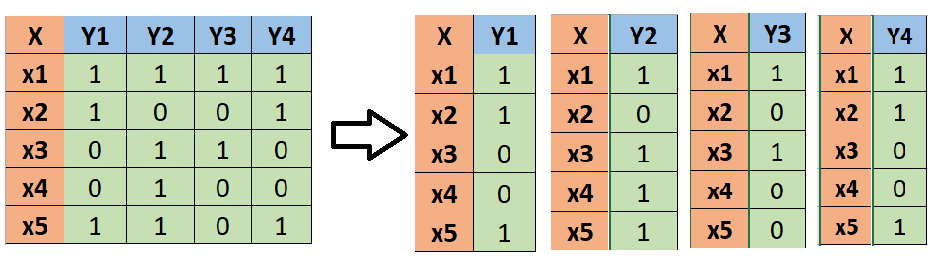

In [ ]:
def cal_metrics(y_true,y_pred,y_pred_proba):

    """function to calculate final metrics """

    if isinstance(y_true,scipy.sparse.lil.lil_matrix):
        y_true=y_true.A
    
    if isinstance(y_pred,scipy.sparse.lil.lil_matrix):
        y_pred=y_pred.A
    
    if isinstance(y_pred_proba,scipy.sparse.lil.lil_matrix):
        y_pred_proba=y_pred_proba.A

    acc=accuracy_score(y_true,y_pred)
    avg_auc=np.mean(roc_auc_score(y_true, y_pred_proba, average=None))
    ham_loss=hamming_loss(y_true,y_pred)
    logloss=log_loss(y_true,y_pred)

    return {"Accuracy":acc,"Average AUC":avg_auc,"Hamming Loss":ham_loss,"Log Loss":logloss}

In [ ]:
def draw_samples(x,y,sample_size,replacement=True):
    
    """custom function to draw the samples"""
    if (len(x)==len(y)):
        indices=np.random.choice(len(x),size=sample_size,replace=replacement)
        return (x[indices],y[indices])
    else:
        print("input arrays are not of equal length")

In [ ]:
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

for base_clf in tqdm(clf_list):
    clf = BinaryRelevance(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba=clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A, average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))

bin_rel_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)','Average AUC',
                                  'Hamming-Loss','Log-Loss'])
bin_rel_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc
bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['Average AUC']=avg_auc
bin_rel_res

,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.765476,0.872074,0.124391,0.669759
1,Logistic Regression,0.904425,0.950750,0.025043,1.457457
2,Decision Tree,0.806464,0.663367,0.046295,2.119595
3,Random Forest,0.907598,0.893898,0.026032,1.403105
4,XGBoost,0.907346,0.951889,0.024598,1.351566


With Binary Relavance (BR), Logistic regression and XGBoost gives pretty similar results with small variations.

SVM is skipped as train time complexity as its training is computationally expensive on larger data-sets like in this case.

We have just used the base classifier with default parameters, If interested we can do hyper parameter tunning. But since Binary relavance doesnt count for correlation between features, we are not using/proceeding with binary relavance

#### 7.1.2 Classifier Chains

Classifier Chains is another simple technique, unlike Binary Relevance Classifier Chain preserves the relationship between the features. The operation of classifier chain works as follows...

classifier-1 will takes all the inputs and fits on the first target labels alone and the classifier-2 takes all the inputs and the first target labels together and fit on the 2nd label. Classifier-3 takes all the inputs and the first, second target labels all together as input and fits on the 3rd target label. and so on

Generalizing the folow as the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.



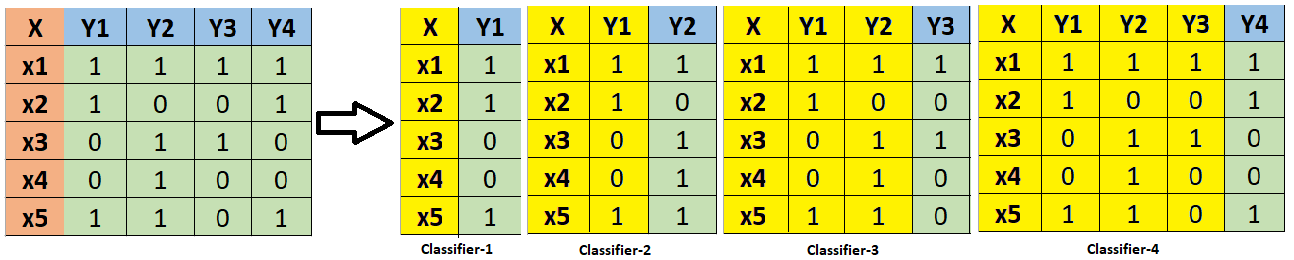

In [ ]:
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

for base_clf in tqdm(clf_list):
    clf = ClassifierChain(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba=clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A, average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))

clf_chain_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)',
                                  'Average AUC','Hamming-Loss','Log-Loss'])
clf_chain_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
clf_chain_res['Exact Match Ratio (Accuracy)']=acc
clf_chain_res['Hamming-Loss']=ham_loss
clf_chain_res['Log-Loss']=logloss
clf_chain_res['Average AUC']=avg_auc
clf_chain_res


,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.764848,0.856806,0.145377,0.473552
1,Logistic Regression,0.906907,0.936180,0.025105,1.103328
2,Decision Tree,0.845127,0.656598,0.046725,1.374427
3,Random Forest,0.909137,0.888660,0.025215,1.132142
4,XGBoost,0.908980,0.938875,0.024572,1.026996


Comparing results with Binary Relavance, Classifier chain metrics have been improved very slightly might be classifiers is able to preserve the correlation between the features and performing well with our data-set

In Classifier chain also the Logistic regression and XGBoost classifier results seems to be and high and very close to each other.

#### 7.1.3 Label Power-Set 

Label Power-Set is a very elegant and best way of transforming multi-label problem to multi-class classification problem. In this approach, we are mapping all unique target labels  under same class label. For example in the below figure, (1,1,1,1) is mapped to class-1 through out all the instances in the dataset. and also (1,0,0,1) is mapped to class-2 throught out all the instances in the dataset. similarly all the unique class labels are are mapped to the same class throught out the data set. 

This Approach preserves the correlation/dependencies between the features. But only disadvantage is that, as the no:of target labels increases, the unique class labels to be mapped is also increased exponentially. And training a such huge multi-class classification problem becomes much more complex and results would be with lower accuracy

for an instance...

2-target labels contains 4 unique combinations

3-target labels contains 8 unique combinations

4-target labels contains 16 unique combinations

n-target labels contains 2^n unique combinations

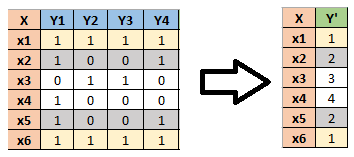

In [ ]:
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

for base_clf in tqdm(clf_list):
    clf = LabelPowerset(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba=clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A, average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))

lbl_pwr_set_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)',
                                  'Average AUC','Hamming-Loss','Log-Loss'])
lbl_pwr_set_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
lbl_pwr_set_res['Exact Match Ratio (Accuracy)']=acc
lbl_pwr_set_res['Hamming-Loss']=ham_loss
lbl_pwr_set_res['Log-Loss']=logloss
lbl_pwr_set_res['Average AUC']=avg_auc
lbl_pwr_set_res

,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.480574,0.849624,0.126611,2.750519
1,Logistic Regression,0.907974,0.953990,0.025257,1.077268
2,Decision Tree,0.839788,0.655490,0.046112,1.390550
3,Random Forest,0.906907,0.911457,0.028053,0.730665
4,XGBoost,0.909168,0.951175,0.025933,0.909725


Label Power-set is the powerful problem transformation technique for multi-label classification problem. 

But our results are very much close to the Binary Relevance and Classifier chain results. In our data-set we have 41 unique combinations (As we seen in the EDA), because of such complexity, Label Power set results are very much close to Binary relevance and classifier chain's. But slightly ahead of both the techniques.

Results of Logistic Regression and XGBoost are also high and close with Label power set.

### 7.2 Ensembles (Custom Stacking)

In this approach, we will implement the custom stacking.


**Steps to implement custom stacking**

1) Randomly split the Training Data-Set into two parts (stratify) say D1, D2

2) Train m-base classifiers of the stacking model using m-different samples sets generated (with replacement) from D1.

3) After training the m-base classifiers, predict the output using D2.

4) Create a data-set, say D3 with the predictions of m-base classifiers and corresponding target labels from D2 as training data-set for meta classifier

5) Train Meta-Classifier of the stacking model using D3 data-set

6) To evaluate final output, create a data set D4 with the predictions with trained m-base classifiers and corresponding y-labels using Testing Data-set.

7) Calculate the final metrics using D4


In [ ]:
#stratify sampling for multi-label classification

X_d1,y_d1, X_d2,y_d2 = iterative_train_test_split(X_train_tfidf_w2v,
                                                y_train,test_size = 0.5)

In [ ]:
print("Shape of X-D1",X_d1.shape)
print("Shape of y-D1",y_d1.shape)
print("\n")
print("Shape of X-D2",X_d2.shape)
print("Shape of y-D2",y_d2.shape)

Shape of X-D1 (63677, 300)
Shape of y-D1 (63677, 6)


Shape of X-D2 (63676, 300)
Shape of y-D2 (63676, 6)


While performing stacking, it is always suggested to perform the hyper parameter tunning of the base classifiers to obtain the better results. So in this session we will perform the Hyper-Parameter Tuning (HPT) on various classifier like Logistic Regression, SVM, Decision Trees, Random Forest, XGBoost 

#### Hyper Paramter Tunning (HPT)

##### HPT-Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [
              {
        'classifier': [LogisticRegression(random_state=42)],
        'classifier__C': [1000,100, 10, 1.0, 0.1, 0.01,0.001]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True)
clf.fit(X_d1, y_d1)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  8.2min finished


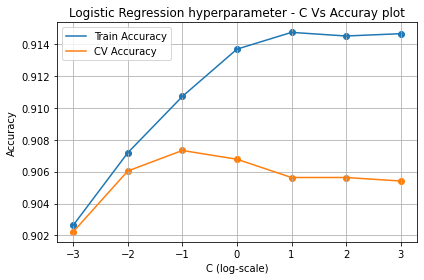

In [ ]:
results = results.sort_values(['param_classifier__C'])

train_acc= results['mean_train_score']
cv_acc = results['mean_test_score']

lr_c = results['param_classifier__C']
#converting type of alpha to apply on numpy
lr_c=lr_c.astype(float)

#considering log scale of alpha for readability
plt.plot(np.log10(lr_c), train_acc, label='Train Accuracy')
plt.plot(np.log10(lr_c), cv_acc, label='CV Accuracy')

plt.scatter(np.log10(lr_c), train_acc)
plt.scatter(np.log10(lr_c), cv_acc)

plt.legend()
plt.xlabel("C (log-scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression hyperparameter - C Vs Accuray plot")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print ("Best hyper parameters for LR are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for LR is ", clf.best_score_)

Best hyper parameters for LR are {'classifier': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.1}


Accuracy with Best hyper parameters for LR is  0.9073279839026306


##### HPT - Liner SVC

In [ ]:
X_d1_svm,y_d1_svm=draw_samples(X_d1,y_d1,sample_size=10000,replacement=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [
              {
        'classifier': [SVC(kernel="linear",random_state=42)],
        'classifier__C': [1000,100, 10, 1.0, 0.1, 0.01,0.001]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True,cv=5)
clf.fit(X_d1_svm, y_d1_svm)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 41.4min finished


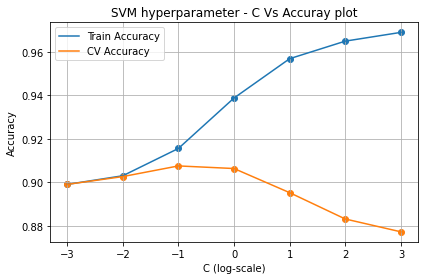

In [ ]:
results = results.sort_values(['param_classifier__C'])

train_acc= results['mean_train_score']
cv_acc = results['mean_test_score']

lr_c = results['param_classifier__C']
#converting type of alpha to apply on numpy
lr_c=lr_c.astype(float)

#considering log scale of alpha for readability
plt.plot(np.log10(lr_c), train_acc, label='Train Accuracy')
plt.plot(np.log10(lr_c), cv_acc, label='CV Accuracy')

plt.scatter(np.log10(lr_c), train_acc)
plt.scatter(np.log10(lr_c), cv_acc)

plt.legend()
plt.xlabel("C (log-scale)")
plt.ylabel("Accuracy")
plt.title("SVM hyperparameter - C Vs Accuray plot")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print ("Best hyper parameters for Linear SVM are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for Linear SVM is ", clf.best_score_)

Best hyper parameters for Linear SVM are {'classifier': SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'classifier__C': 0.1}


Accuracy with Best hyper parameters for Linear SVM is  0.9075


##### HPT- RBF SVM

In [ ]:
X_d1_svm,y_d1_svm=draw_samples(X_d1,y_d1,sample_size=30000,replacement=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [
              {
        'classifier': [SVC(kernel="rbf",random_state=42)],
        'classifier__C': [1000,100, 10, 1.0, 0.1, 0.01,0.001]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True,cv=5)
clf.fit(X_d1_svm, y_d1_svm)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 53.3min finished


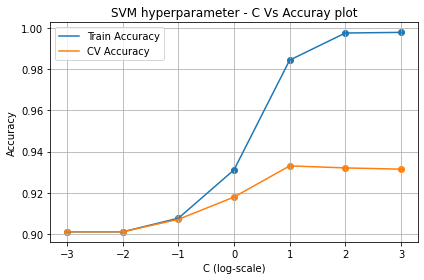

In [ ]:
results = results.sort_values(['param_classifier__C'])

train_acc= results['mean_train_score']
cv_acc = results['mean_test_score']

lr_c = results['param_classifier__C']
#converting type of alpha to apply on numpy
lr_c=lr_c.astype(float)

#considering log scale of alpha for readability
plt.plot(np.log10(lr_c), train_acc, label='Train Accuracy')
plt.plot(np.log10(lr_c), cv_acc, label='CV Accuracy')

plt.scatter(np.log10(lr_c), train_acc)
plt.scatter(np.log10(lr_c), cv_acc)

plt.legend()
plt.xlabel("C (log-scale)")
plt.ylabel("Accuracy")
plt.title("SVM hyperparameter - C Vs Accuray plot")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print ("Best hyper parameters for RBF SVM are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for RBF SVM is ", clf.best_score_)

Best hyper parameters for RBF SVM are {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'classifier__C': 10}


Accuracy with Best hyper parameters for RBF SVM is  0.9330666666666667


##### HPT- SVM Poly

In [ ]:
X_d1_svm,y_d1_svm=draw_samples(X_d1,y_d1,sample_size=30000,replacement=True)

In [ ]:


parameters = [
              {
        'classifier': [SVC(kernel="poly",random_state=42)],
        'classifier__C': [1000,100, 10, 1.0, 0.1, 0.01,0.001]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True,cv=5)
clf.fit(X_d1_svm, y_d1_svm)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 64.7min finished


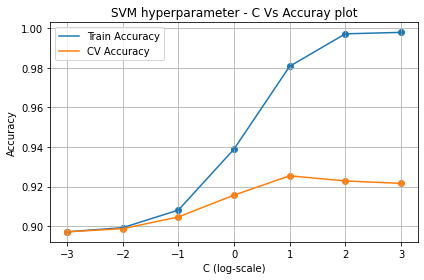

In [ ]:
results = results.sort_values(['param_classifier__C'])

train_acc= results['mean_train_score']
cv_acc = results['mean_test_score']

lr_c = results['param_classifier__C']
#converting type of alpha to apply on numpy
lr_c=lr_c.astype(float)

#considering log scale of alpha for readability
plt.plot(np.log10(lr_c), train_acc, label='Train Accuracy')
plt.plot(np.log10(lr_c), cv_acc, label='CV Accuracy')

plt.scatter(np.log10(lr_c), train_acc)
plt.scatter(np.log10(lr_c), cv_acc)

plt.legend()
plt.xlabel("C (log-scale)")
plt.ylabel("Accuracy")
plt.title("SVM hyperparameter - C Vs Accuray plot")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print ("Best hyper parameters for SVM with Poly kernel are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for SVM with poly kernel is ", clf.best_score_)

Best hyper parameters for SVM with Poly kernel are {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'classifier__C': 10}


Accuracy with Best hyper parameters for SVM with poly kernel is  0.9254333333333333


##### HPT-DT

In [ ]:
parameters = [
              {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [1, 5, 10, 50,100],
        'classifier__min_samples_split':[5, 10, 100, 500,1000]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True)
clf.fit(X_d1, y_d1)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 33.8min finished


Text(0.5, 1.0, 'Accuracy for CV data')

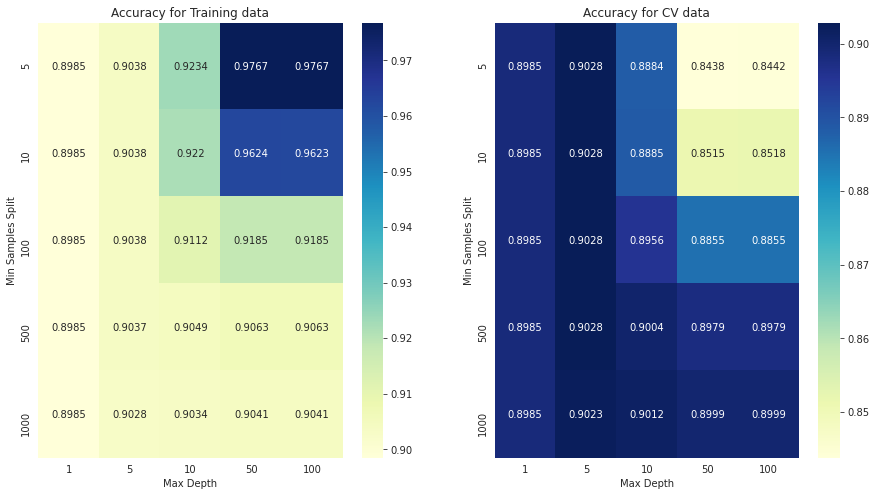

In [ ]:
#plotting the Heat map for Hyper-parametr tuning

max_depth_list = results['param_classifier__max_depth'].values
min_samples_split_list = results['param_classifier__min_samples_split'].values

sns.set_style("whitegrid")
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
data = pd.DataFrame(data={'Min Samples Split':min_samples_split_list, 
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_train_score']})

data = data.pivot(index='Min Samples Split',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt='.4g').set_title('Accuracy for Training data')

plt.subplot(1,2,2)
data = pd.DataFrame(data={'Min Samples Split':min_samples_split_list,
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_test_score']})

data = data.pivot(index='Min Samples Split',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt=".4g").set_title('Accuracy for CV data')

In [ ]:
print ("Best hyper parameters for DT are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for DT is ", clf.best_score_)

Best hyper parameters for DT are {'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), 'classifier__max_depth': 5, 'classifier__min_samples_split': 500}


Accuracy with Best hyper parameters for DT is  0.9028363709497628


##### HPT-RF

In [ ]:
parameters = [
              {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__max_depth': [1, 5, 10, 50,100],
        'classifier__n_estimators':[50,100,200,300,500]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True)
clf.fit(X_d1, y_d1)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 220.9min finished


Text(0.5, 1.0, 'Accuracy for CV data')

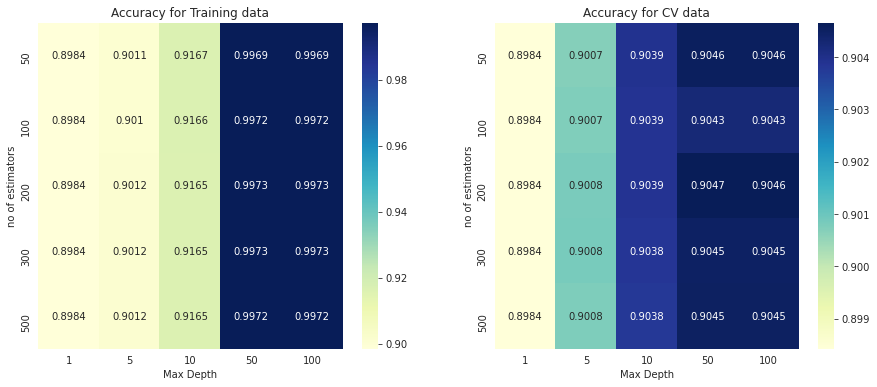

In [ ]:
#plotting the Heat map for Hyper-parametr tuning

max_depth_list = results['param_classifier__max_depth'].values
no_of_estimators_list = results['param_classifier__n_estimators'].values

sns.set_style("whitegrid")
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
data = pd.DataFrame(data={'no of estimators':no_of_estimators_list, 
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_train_score']})

data = data.pivot(index='no of estimators',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt='.4g').set_title('Accuracy for Training data')

plt.subplot(1,2,2)
data = pd.DataFrame(data={'no of estimators':no_of_estimators_list, 
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_test_score']})

data = data.pivot(index='no of estimators',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt=".4g").set_title('Accuracy for CV data')

In [ ]:
print ("Best hyper parameters for Random Forest are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for Random Forest is ", clf.best_score_)

Best hyper parameters for Random Forest are {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'classifier__max_depth': 50, 'classifier__n_estimators': 200}


Accuracy with Best hyper parameters for Random Forest is  0.9046580850364899


##### HPT- XGBoost

In [ ]:
X_d1_xgb,y_d1_xgb=draw_samples(X_d1,y_d1,sample_size=10000,replacement=True)

In [ ]:
parameters = [
              {
        'classifier': [XGBClassifier(random_state=42)],
        'classifier__max_depth': [1, 3, 5, 7,9],
        'classifier__n_estimators':[100,200,300,400,500]
        }
              ]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy',n_jobs=-1,
                   verbose=1,return_train_score=True,cv=3)
clf.fit(X_d1_xgb, y_d1_xgb)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 131.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 258.3min finished


Text(0.5, 1.0, 'Accuracy for CV data')

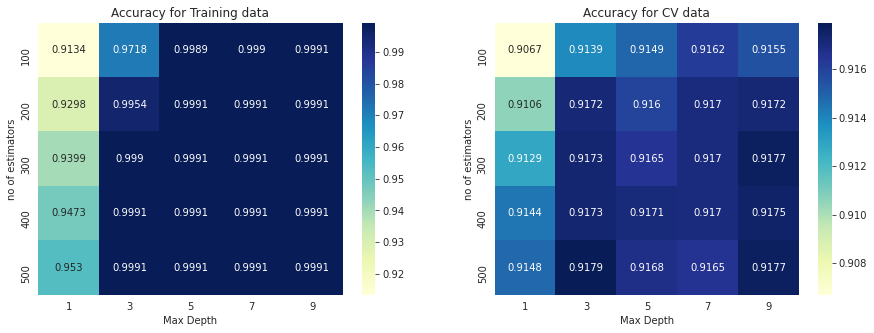

In [ ]:
#plotting the Heat map for Hyper-parametr tuning

max_depth_list = results['param_classifier__max_depth'].values
no_of_estimators_list = results['param_classifier__n_estimators'].values

sns.set_style("whitegrid")
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
data = pd.DataFrame(data={'no of estimators':no_of_estimators_list, 
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_train_score']})

data = data.pivot(index='no of estimators',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt='.4g').set_title('Accuracy for Training data')

plt.subplot(1,2,2)
data = pd.DataFrame(data={'no of estimators':no_of_estimators_list, 
                          'Max Depth':max_depth_list,
                          'Accuracy':clf.cv_results_['mean_test_score']})

data = data.pivot(index='no of estimators',columns='Max Depth', values='Accuracy')

sns.heatmap(data, annot=True, cmap="YlGnBu",fmt=".4g").set_title('Accuracy for CV data')

In [ ]:
print ("Best hyper parameters for XGBDT are",clf.best_params_)
print("\n")
print("Accuracy with Best hyper parameters for XGBDT is ", clf.best_score_)

Best hyper parameters for XGBDT are {'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 'classifier__max_depth': 3, 'classifier__n_estimators': 500}


Accuracy with Best hyper parameters for XGBDT is  0.9179001883391699


**Summary on Hyper-parameter tunning**

1) SVM/XGBT is computed on a sample of 10k,30k points as it is computationally expensive.

2) Among all of the classifiers, RBF SVM gives the highest metric and followed by poly-SVM and XGBDT

3) Other classifiers like LR, DT, RF gave very similar metrics, with very slight variations

#### Stacking Implementation & Training

In [ ]:
def custom_stacking(base_clfs,meta_clf,xtrain,ytrain,xval,yval,meta_xval,meta_yval,sample_size):

    """function to perform custom stacking"""

    proc_id = os.getpid()
    print("One Process Started with Id-",proc_id)

    if len(xtrain)==len(ytrain) and len(xval)==len(yval) and len(meta_xval)==len(meta_yval):
        base_clf_x_tr_samples=[]
        base_clf_y_tr_samples=[]
        
        # getting samples for base classifiers
        for k in range(len(base_clfs)):
            x,y=draw_samples(xtrain,ytrain,sample_size,replacement=True)
            base_clf_x_tr_samples.append(x)
            base_clf_y_tr_samples.append(y)

        meta_clf_tr_x_data=np.empty(shape=(0,yval.shape[1]),dtype=yval.dtype)
        meta_clf_tr_y_data =np.empty(shape=(0,yval.shape[1]),dtype=yval.dtype)

        meta_clf_te_x_data=np.empty(shape=(0,yval.shape[1]),dtype=yval.dtype)
        meta_clf_te_y_data =np.empty(shape=(0,yval.shape[1]),dtype=yval.dtype)

        print("Training Base Classifiers on Proc Id-",proc_id)
        #base classifiers training
        for clf,x_base,y_base in tqdm(zip(base_clfs,base_clf_x_tr_samples,base_clf_y_tr_samples),total=len(base_clfs)):
            clf.fit(x_base,y_base)

            #preparing train data-set for meta classifier
            pred = clf.predict(xval)
            pred=pred.A
            meta_clf_tr_x_data=np.append(meta_clf_tr_x_data,pred,axis=0)
            meta_clf_tr_y_data=np.append(meta_clf_tr_y_data,yval,axis=0)

            #preparing test data-set for meta classifier
            pred = clf.predict(meta_xval)
            pred=pred.A
            meta_clf_te_x_data=np.append(meta_clf_te_x_data,pred,axis=0)
            meta_clf_te_y_data=np.append(meta_clf_te_y_data,meta_yval,axis=0)
        
        print("Completed Training Base Classifiers on Proc Id-",proc_id)
      
        print("Training Meta Classifier on Proc Id-",proc_id)
        

        #meta classifier training
        meta_op=meta_clf.fit(meta_clf_tr_x_data,meta_clf_tr_y_data)

        #meta classifier predictions
        pred = meta_op.predict(meta_clf_te_x_data)
        pred=pred.A
        pred_proba=meta_op.predict_proba(meta_clf_te_x_data)
        pred_proba=pred_proba.A

        print("Completed Training Meta Classifier on Proc Id-",proc_id)
        return cal_metrics(meta_clf_te_y_data,pred,pred_proba)
    
    else:
        print("Inputs are not of same shape. Please correct input(s)")    

Now Lets us train stacked models using multi processing....To get better results we will use models with the hyper parameters tuned above.

In [ ]:
#defining base-classifier objects as per the best hyper-parameters

log_reg=LabelPowerset(LogisticRegression(random_state=42,C=0.1))
lin_svm=LabelPowerset(SVC(kernel="linear",random_state=42,C=0.1,probability=True))
rbf_svm=LabelPowerset(SVC(kernel="rbf",random_state=42,C=10,probability=True))
poly_svm=LabelPowerset(SVC(kernel="poly",random_state=42,C=10,probability=True))
dec_tree=LabelPowerset(DecisionTreeClassifier(random_state=42,max_depth=5,min_samples_split=500))
ran_frst=LabelPowerset(RandomForestClassifier(random_state=42,max_depth=10,n_estimators=200))
xgbst=LabelPowerset(XGBClassifier(random_state=42,max_depth=1,n_estimators=400))

###### Training Stacking Model With Set of 4 randomly choosen Base Classifiers 

**With 10k Samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,ran_frst,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_2= ([poly_svm,dec_tree,xgbst,log_reg],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_3= ([lin_svm,ran_frst,xgbst,dec_tree],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_4= ([rbf_svm,poly_svm,xgbst,log_reg],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

One Process Started with Id- 3932
Training Base Classifiers on Proc Id- 3932


One Process Started with Id- 3933
Training Base Classifiers on Proc Id- 3933


One Process Started with Id- 3934
One Process Started with Id- 3935
Training Base Classifiers on Proc Id- 3934
Training Base Classifiers on Proc Id- 3935



Completed Training Base Classifiers on Proc Id- 3934
Training Meta Classifier on Proc Id- 3934

Completed Training Base Classifiers on Proc Id- 3932
Training Meta Classifier on Proc Id- 3932

Completed Training Base Classifiers on Proc Id- 3933
Training Meta Classifier on Proc Id- 3933
Completed Training Meta Classifier on Proc Id- 3932

Completed Training Base Classifiers on Proc Id- 3935
Training Meta Classifier on Proc Id- 3935
Completed Training Meta Classifier on Proc Id- 3935
Completed Training Meta Classifier on Proc Id- 3934
Completed Training Meta Classifier on Proc Id- 3933


In [ ]:
for i in results:
    print(i)

{'Accuracy': 0.9062627595087785, 'Average AUC': 0.7347433827903815, 'Hamming Loss': 0.028439963566694933, 'Log Loss': 0.7101031623299845}
{'Accuracy': 0.9051006627092559, 'Average AUC': 0.6667418547066294, 'Hamming Loss': 0.029760409141828155, 'Log Loss': 0.6505987079600607}
{'Accuracy': 0.9041348660447879, 'Average AUC': 0.6404954670825317, 'Hamming Loss': 0.030874085241370645, 'Log Loss': 0.6039106360898664}
{'Accuracy': 0.9079116806432362, 'Average AUC': 0.7830413328997894, 'Hamming Loss': 0.026966403886219206, 'Log Loss': 0.7502652626141352}


**With 30K samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,ran_frst,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_2= ([poly_svm,dec_tree,xgbst,log_reg],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_3= ([lin_svm,ran_frst,xgbst,dec_tree],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_4= ([rbf_svm,poly_svm,xgbst,log_reg],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 359
Training Base Classifiers on Proc Id- 359


One Process Started with Id- 360
Training Base Classifiers on Proc Id- 360


One Process Started with Id- 361
Training Base Classifiers on Proc Id- 361


One Process Started with Id- 362
Training Base Classifiers on Proc Id- 362



Completed Training Base Classifiers on Proc Id- 361
Training Meta Classifier on Proc Id- 361
Completed Training Meta Classifier on Proc Id- 361

Completed Training Base Classifiers on Proc Id- 359
Training Meta Classifier on Proc Id- 359
Completed Training Meta Classifier on Proc Id- 359

Completed Training Base Classifiers on Proc Id- 360
Training Meta Classifier on Proc Id- 360

Completed Training Base Classifiers on Proc Id- 362
Training Meta Classifier on Proc Id- 362
Completed Training Meta Classifier on Proc Id- 362
Completed Training Meta Classifier on Proc Id- 360
{'Accuracy': 0.9078645686108232, 'Average AUC': 0.7469413882253093, 'Hamming Loss': 0.027208507386119747, 'Log Loss': 0.7623686909437097}
{'Accuracy': 0.9069615879895725, 'Average AUC': 0.7040295717556614, 'Hamming Loss': 0.02803689395604971, 'Log Loss': 0.6963722814591419}
{'Accuracy': 0.9054697069631584, 'Average AUC': 0.6798049102463857, 'Hamming Loss': 0.029144026717757048, 'Log Loss': 0.7327144602458421}
{'Accur

**With Complete D1-Size Samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,ran_frst,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

ip_2= ([poly_svm,dec_tree,xgbst,log_reg],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

ip_3= ([lin_svm,ran_frst,xgbst,dec_tree],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

ip_4= ([rbf_svm,poly_svm,xgbst,log_reg],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 1481
Training Base Classifiers on Proc Id- 1481


One Process Started with Id- 1482
Training Base Classifiers on Proc Id- 1482


One Process Started with Id- 1483
Training Base Classifiers on Proc Id- 1483


One Process Started with Id- 1484
Training Base Classifiers on Proc Id- 1484



Completed Training Base Classifiers on Proc Id- 1483
Training Meta Classifier on Proc Id- 1483
Completed Training Meta Classifier on Proc Id- 1483

Completed Training Base Classifiers on Proc Id- 1481
Training Meta Classifier on Proc Id- 1481
Completed Training Meta Classifier on Proc Id- 1481

Completed Training Base Classifiers on Proc Id- 1482
Training Meta Classifier on Proc Id- 1482
Completed Training Meta Classifier on Proc Id- 1482

Completed Training Base Classifiers on Proc Id- 1484
Training Meta Classifier on Proc Id- 1484
Completed Training Meta Classifier on Proc Id- 1484
{'Accuracy': 0.9082414648701278, 'Average AUC': 0.7540179749784989, 'Hamming Loss': 0.02687217982139305, 'Log Loss': 0.7386257843999656}
{'Accuracy': 0.9073149282326706, 'Average AUC': 0.7195004392146709, 'Hamming Loss': 0.027382560172534733, 'Log Loss': 0.7598454798447232}
{'Accuracy': 0.9063020195357895, 'Average AUC': 0.6814940047576415, 'Hamming Loss': 0.028573447658531988, 'Log Loss': 0.7305529118215

##### Training Stacking Model With Set of 3 randomly choosen Base Classifiers

**With 10K Samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_2= ([poly_svm,dec_tree,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_3= ([lin_svm,ran_frst,xgbst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_4= ([rbf_svm,poly_svm,xgbst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 434
Training Base Classifiers on Proc Id- 434


One Process Started with Id- 435
Training Base Classifiers on Proc Id- 435


One Process Started with Id- 437
Training Base Classifiers on Proc Id- 437


One Process Started with Id- 439
Training Base Classifiers on Proc Id- 439



Completed Training Base Classifiers on Proc Id- 437
Training Meta Classifier on Proc Id- 437

Completed Training Base Classifiers on Proc Id- 434
Training Meta Classifier on Proc Id- 434

Completed Training Base Classifiers on Proc Id- 435
Training Meta Classifier on Proc Id- 435
Completed Training Meta Classifier on Proc Id- 434

Completed Training Base Classifiers on Proc Id- 439
Training Meta Classifier on Proc Id- 439
Completed Training Meta Classifier on Proc Id- 437
Completed Training Meta Classifier on Proc Id- 439
Completed Training Meta Classifier on Proc Id- 435
{'Accuracy': 0.9081734141566423, 'Average AUC': 0.7752211725242607, 'Hamming Loss': 0.026588635181869893, 'Log Loss': 0.7560255189524234}
{'Accuracy': 0.9040799020069726, 'Average AUC': 0.6613335664889226, 'Hamming Loss': 0.030505913432512886, 'Log Loss': 0.6406142328548604}
{'Accuracy': 0.9061633007736842, 'Average AUC': 0.6937448844594271, 'Hamming Loss': 0.028541167191878585, 'Log Loss': 0.7095192340154082}
{'Accu

**With 30K Samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_4= ([rbf_svm,poly_svm,xgbst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 504
Training Base Classifiers on Proc Id- 504


One Process Started with Id- 505
Training Base Classifiers on Proc Id- 505



Completed Training Base Classifiers on Proc Id- 504
Training Meta Classifier on Proc Id- 504
Completed Training Meta Classifier on Proc Id- 504

Completed Training Base Classifiers on Proc Id- 505
Training Meta Classifier on Proc Id- 505
Completed Training Meta Classifier on Proc Id- 505
{'Accuracy': 0.9090842467832951, 'Average AUC': 0.7861602981514876, 'Hamming Loss': 0.026070402825326033, 'Log Loss': 0.764254640462534}
{'Accuracy': 0.9094192656804548, 'Average AUC': 0.800825806794997, 'Hamming Loss': 0.025864505794779988, 'Log Loss': 0.7338032805508126}


**With Same as D1 Size Samples...**

In [ ]:
ip_1= ([log_reg,rbf_svm,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

ip_2= ([poly_svm,dec_tree,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))


total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 384
Training Base Classifiers on Proc Id- 384


One Process Started with Id- 385
Training Base Classifiers on Proc Id- 385



Completed Training Base Classifiers on Proc Id- 384
Training Meta Classifier on Proc Id- 384
Completed Training Meta Classifier on Proc Id- 384

Completed Training Base Classifiers on Proc Id- 385
Training Meta Classifier on Proc Id- 385
Completed Training Meta Classifier on Proc Id- 385
{'Accuracy': 0.9098903860045856, 'Average AUC': 0.7850607985609243, 'Hamming Loss': 0.025550425578692797, 'Log Loss': 0.7964654838259033}
{'Accuracy': 0.9066867678004963, 'Average AUC': 0.694654013206455, 'Hamming Loss': 0.028113669119982133, 'Log Loss': 0.6876443401632297}


##### Training Stacking Model With Set of 2 randomly choosen Base Classifiers

**With 10K Samples...**

In [ ]:
ip_1= ([dec_tree,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_2= ([log_reg,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_3= ([rbf_svm,ran_frst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_4= ([rbf_svm,poly_svm],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 1018
Training Base Classifiers on Proc Id- 1018


One Process Started with Id- 1019
Training Base Classifiers on Proc Id- 1019


One Process Started with Id- 1020
Training Base Classifiers on Proc Id- 1020


One Process Started with Id- 1021
Training Base Classifiers on Proc Id- 1021



Completed Training Base Classifiers on Proc Id- 1020
Training Meta Classifier on Proc Id- 1020

Completed Training Base Classifiers on Proc Id- 1021
Training Meta Classifier on Proc Id- 1021

Completed Training Base Classifiers on Proc Id- 1019
Training Meta Classifier on Proc Id- 1019

Completed Training Base Classifiers on Proc Id- 1018
Training Meta Classifier on Proc Id- 1018
Completed Training Meta Classifier on Proc Id- 1021
Completed Training Meta Classifier on Proc Id- 1018
Completed Training Meta Classifier on Proc Id- 1020
Completed Training Meta Classifier on Proc Id- 1019
{'Accuracy': 0.9033732215207764, 'Average AUC': 0.6270331694598922, 'Hamming Loss': 0.0316802244626611, 'Log Loss': 0.5646550410801457}
{'Accuracy': 0.9075190803731273, 'Average AUC': 0.7312662122901245, 'Hamming Loss': 0.027065862621313483, 'Log Loss': 0.7410282658863442}
{'Accuracy': 0.9068595119193442, 'Average AUC': 0.7181878940701879, 'Hamming Loss': 0.028091857993864967, 'Log Loss': 0.71832240313124

**With 30K Samples...**

In [ ]:
ip_1= ([dec_tree,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_2= ([log_reg,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_3= ([rbf_svm,ran_frst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_4= ([rbf_svm,poly_svm],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 1792
Training Base Classifiers on Proc Id- 1792


One Process Started with Id- 1793
Training Base Classifiers on Proc Id- 1793


One Process Started with Id- 1794
Training Base Classifiers on Proc Id- 1794


One Process Started with Id- 1795
Training Base Classifiers on Proc Id- 1795



Completed Training Base Classifiers on Proc Id- 1794
Training Meta Classifier on Proc Id- 1794

Completed Training Base Classifiers on Proc Id- 1793
Training Meta Classifier on Proc Id- 1793

Completed Training Base Classifiers on Proc Id- 1792
Training Meta Classifier on Proc Id- 1792
Completed Training Meta Classifier on Proc Id- 1794
Completed Training Meta Classifier on Proc Id- 1792
Completed Training Meta Classifier on Proc Id- 1793

Completed Training Base Classifiers on Proc Id- 1795
Training Meta Classifier on Proc Id- 1795
Completed Training Meta Classifier on Proc Id- 1795
{'Accuracy': 0.9054461509469518, 'Average AUC': 0.6744605135319272, 'Hamming Loss': 0.029429316247369577, 'Log Loss': 0.6677146536412477}
{'Accuracy': 0.9082414648701278, 'Average AUC': 0.7229306294057068, 'Hamming Loss': 0.02663661965932766, 'Log Loss': 0.76747269596003}
{'Accuracy': 0.9076133044379534, 'Average AUC': 0.7287668124452414, 'Hamming Loss': 0.027576242972455166, 'Log Loss': 0.738183732132157

**Same as D1 Size Samples...**

In [ ]:
ip_1= ([dec_tree,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

ip_3= ([rbf_svm,ran_frst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_3])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 450
Training Base Classifiers on Proc Id- 450


One Process Started with Id- 451
Training Base Classifiers on Proc Id- 451



Completed Training Base Classifiers on Proc Id- 450
Training Meta Classifier on Proc Id- 450
Completed Training Meta Classifier on Proc Id- 450

Completed Training Base Classifiers on Proc Id- 451
Training Meta Classifier on Proc Id- 451
Completed Training Meta Classifier on Proc Id- 451
{'Accuracy': 0.9054932629793649, 'Average AUC': 0.6833557488066487, 'Hamming Loss': 0.029345561523079662, 'Log Loss': 0.6592993001061322}
{'Accuracy': 0.9081158327836929, 'Average AUC': 0.7397038301394385, 'Hamming Loss': 0.027314509459049174, 'Log Loss': 0.7287205058288668}


In [ ]:
ip_2= ([log_reg,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))


ip_4= ([rbf_svm,poly_svm],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,len(X_d1))

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_2,ip_4])
    pool_obj.close()

for i in results:
    print(i)

##### Training Stacking Model With Set of All Base Classifiers

**With 10K Samples...**

In [ ]:
ip_1= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_2= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_3= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

ip_4= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,10000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 387
Training Base Classifiers on Proc Id- 387


One Process Started with Id- 388
Training Base Classifiers on Proc Id- 388


One Process Started with Id- 389
Training Base Classifiers on Proc Id- 389


One Process Started with Id- 390
Training Base Classifiers on Proc Id- 390



Completed Training Base Classifiers on Proc Id- 390
Training Meta Classifier on Proc Id- 390

Completed Training Base Classifiers on Proc Id- 388
Training Meta Classifier on Proc Id- 388

Completed Training Base Classifiers on Proc Id- 387
Training Meta Classifier on Proc Id- 387

Completed Training Base Classifiers on Proc Id- 389
Training Meta Classifier on Proc Id- 389
Completed Training Meta Classifier on Proc Id- 390
Completed Training Meta Classifier on Proc Id- 387
Completed Training Meta Classifier on Proc Id- 389
Completed Training Meta Classifier on Proc Id- 388
{'Accuracy': 0.9057131191306259, 'Average AUC': 0.7275696513177108, 'Hamming Loss': 0.02855512631259357, 'Log Loss': 0.7110453719101846}
{'Accuracy': 0.9056906848294769, 'Average AUC': 0.7020469282140006, 'Hamming Loss': 0.02853942230178921, 'Log Loss': 0.7182580434866603}
{'Accuracy': 0.9056772242487874, 'Average AUC': 0.7275979228793563, 'Hamming Loss': 0.02855288288247866, 'Log Loss': 0.7141140843063324}
{'Accurac

**With 30K Samples...**

In [ ]:
ip_1= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],log_reg,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_2= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],rbf_svm,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_3= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],xgbst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

ip_4= ([log_reg,lin_svm,rbf_svm,poly_svm,dec_tree,ran_frst,xgbst],ran_frst,X_d1,y_d1,X_d2,y_d2,
    X_test_tfidf_w2v,y_test,30000)

total_no_of_proc=multiprocessing.cpu_count()

with Pool(total_no_of_proc) as pool_obj:        
    results=pool_obj.starmap(custom_stacking,[ip_1,ip_2,ip_3,ip_4])
    pool_obj.close()

for i in results:
    print(i)

One Process Started with Id- 2751
Training Base Classifiers on Proc Id- 2751


One Process Started with Id- 2752
Training Base Classifiers on Proc Id- 2752


One Process Started with Id- 2753
Training Base Classifiers on Proc Id- 2753


One Process Started with Id- 2754
Training Base Classifiers on Proc Id- 2754



Completed Training Base Classifiers on Proc Id- 2751
Training Meta Classifier on Proc Id- 2751

Completed Training Base Classifiers on Proc Id- 2753
Training Meta Classifier on Proc Id- 2753
Completed Training Meta Classifier on Proc Id- 2751

Completed Training Base Classifiers on Proc Id- 2754
Training Meta Classifier on Proc Id- 2754
Completed Training Meta Classifier on Proc Id- 2754

Completed Training Base Classifiers on Proc Id- 2752
Training Meta Classifier on Proc Id- 2752
Completed Training Meta Classifier on Proc Id- 2753
Completed Training Meta Classifier on Proc Id- 2752
{'Accuracy': 0.9072162173076147, 'Average AUC': 0.7309204867621446, 'Hamming Loss': 0.027585216692914798, 'Log Loss': 0.7455247950274542}
{'Accuracy': 0.907207243587155, 'Average AUC': 0.7123222510008843, 'Hamming Loss': 0.027594190413374433, 'Log Loss': 0.7462561184324721}
{'Accuracy': 0.9072207041678445, 'Average AUC': 0.7308358711340985, 'Hamming Loss': 0.02757773859253177, 'Log Loss': 0.74873710777660

**Summary on Stacking Models**

1) Unfortunately any of the custom staking models, didnt give considerable improvements in the metrics.

2) Accuracy and Hamming Loss with stacking seems to be same like as with the Label Power set.

3) Average AUC has been droped for most of the stacked models

4) Log-loss has been improved for stacked models.

### 7.3 MLP

Natively, Neural Networks (NN) are able to solve multi-label clasification problems. In case of multi class classification, generally we choose categorical cross entropy as loss function and soft-max as the activations in the output layer. But for a multi-label classsification we just need to choose the loss function as Binary cross entropy and and sigmoid activations in the output layer.

In [ ]:
class custom_callbacks(tf.keras.callbacks.Callback):
  #this is a custom call back 

    def __init__(self,training_data,validation_data,acc_threshold,auc_threshold,filepath):

        super(custom_callbacks, self).__init__()
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.acc_threshold = acc_threshold
        self.auc_threshold = auc_threshold
        self.best_metric= float("inf")
        self.filepath=filepath

    def on_train_begin(self, logs={}):

        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys exact match ratio (accuracy), hamming loss,
        # average AUC (calculated AUC on each column and made average) and logloss
    
        self.history={'EMR': [],'val_EMR': [],'ham_loss': [],'val_ham_loss': [],
                      'log_loss':[],'val_log_loss':[],'avg_AUC':[],'val_avg_AUC':[]}                      

    def on_epoch_end(self, epoch, logs={}):
        # on end of each epoch, we will get logs and update the self.history dict

        #predicts on train data

        predict_train_proba = np.asarray(self.model.predict(self.x))
        predict_train = (np.asarray(self.model.predict(self.x))).round()
        train_metrics= cal_metrics(self.y,predict_train,predict_train_proba)

        self.history['EMR'].append(train_metrics['Accuracy'])
        self.history['avg_AUC'].append(train_metrics['Average AUC'])
        self.history['ham_loss'].append(train_metrics['Hamming Loss'])
        self.history['log_loss'].append(train_metrics['Log Loss'])

        #predicts on test data

        predict_test_proba = np.asarray(self.model.predict(self.x_val))
        predict_test = (np.asarray(self.model.predict(self.x_val))).round()
        test_metrics= cal_metrics(self.y_val,predict_test,predict_test_proba)

        self.history['val_EMR'].append(test_metrics['Accuracy'])
        self.history['val_avg_AUC'].append(test_metrics['Average AUC'])
        self.history['val_ham_loss'].append(test_metrics['Hamming Loss'])
        self.history['val_log_loss'].append(test_metrics['Log Loss'])

        print("-EMR :",round(train_metrics['Accuracy'],4),
              "-val_EMR:",round(test_metrics['Accuracy'],4),
              "-avg_AUC:",round(train_metrics['Average AUC'],4),
              "-val_avg_AUC:",round(test_metrics['Average AUC'],4),
              "-Hamming_Loss:",round(train_metrics['Hamming Loss'],4),
              "-val_Hamming_Loss:",round(test_metrics['Hamming Loss'],4),
              "-Log_Loss:",round(train_metrics['Log Loss'],4),
              "-val_Log_Loss:",round(test_metrics['Log Loss'],4))
              
        print("\n")
        
        if (self.best_metric>test_metrics['Hamming Loss']):
            print("val_Hamming_Loss has been improved from ",round(self.best_metric,4)," to ",round(test_metrics['Hamming Loss'],4),"So, Saving model to ",self.filepath)
            self.model.save(self.filepath)
            self.best_metric=test_metrics['Hamming Loss']
        else:
            print("val_Hamming_Loss has not been improved from ",round(self.best_metric,4))
        
        #custom code stop training after reaching a particular parameter to a threshold
        if (test_metrics['Accuracy'] >= self.acc_threshold) and (test_metrics['Average AUC'] >= self.auc_threshold) :
            print("Metrics reached the threshold... So, Termination")
            self.model.stop_training = True  
        print("\n")

In [ ]:
#creating an object for the custom call back class
call_back=custom_callbacks(training_data=(X_train_tfidf_w2v,y_train),
                           validation_data=(X_test_tfidf_w2v,y_test),
                           acc_threshold=0.91,
                           auc_threshold=0.95,
                           filepath="/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/mlp_model.h5")

In [ ]:
#input layer
input_layer = Input(shape=X_train_tfidf_w2v.shape[1:],
                    name='Input_Layer')

FC1 = Dense(units=256,activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
            name='FC1')(input_layer)

FC2 = Dense(units=128,activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
            name='FC2')(FC1)

DP1=Dropout(rate=0.3)(FC2)

FC3 = Dense(units=64,activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
            name='FC3')(DP1)

BN1=BatchNormalization()(FC3)

FC4 = Dense(units=32,activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
            name='FC4')(BN1)

#Output Layer
Out = Dense(units=y_train.shape[1],activation='sigmoid',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
            bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
            name='Output')(FC4)

In [ ]:
model = Model(inputs=input_layer,outputs=Out,name="MLP")

In [ ]:
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 300)]             0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               77056     
_________________________________________________________________
FC2 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
FC3 (Dense)                  (None, 64)                8256      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
FC4 (Dense)                  (None, 32)                2080    

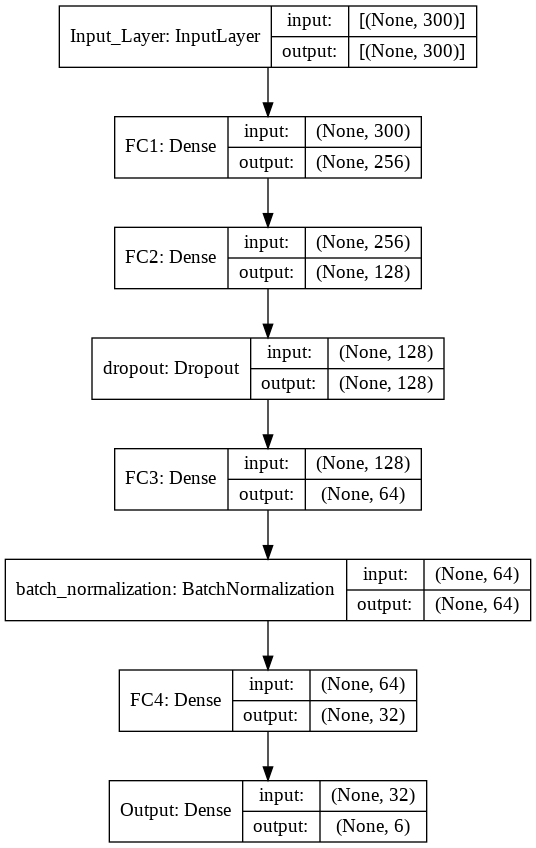

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/mlp_model.png',
     show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB',
     expand_nested=False, dpi=96
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=["binary_accuracy"])

In [ ]:
model.fit(X_train_tfidf_w2v,y_train,
          epochs=20,
          validation_data=(X_test_tfidf_w2v,y_test), 
          batch_size=64,
          callbacks=[call_back]
          )

Epoch 1/20
1990/1990 [==============================] - 25s 6ms/step - loss: 0.1745 - binary_accuracy: 0.9715 - val_loss: 0.1048 - val_binary_accuracy: 0.9755
-EMR : 0.9056 -val_EMR: 0.9026 -avg_AUC: 0.9384 -val_avg_AUC: 0.942 -Hamming_Loss: 0.0238 -val_Hamming_Loss: 0.0245 -Log_Loss: 1.4694 -val_Log_Loss: 1.5618


val_Hamming_Loss has been improved from  inf  to  0.0245 So, Saving model to  /content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/mlp_model.h5


Epoch 2/20
1990/1990 [==============================] - 11s 6ms/step - loss: 0.0911 - binary_accuracy: 0.9759 - val_loss: 0.0917 - val_binary_accuracy: 0.9734
-EMR : 0.8937 -val_EMR: 0.8914 -avg_AUC: 0.9481 -val_avg_AUC: 0.9483 -Hamming_Loss: 0.0259 -val_Hamming_Loss: 0.0266 -Log_Loss: 1.4208 -val_Log_Loss: 1.4644


val_Hamming_Loss has not been improved from  0.0245


Epoch 3/20
1990/1990 [==============================] - 12s 6ms/step - loss: 0.0878 - binary_accuracy: 0.9761 - val_loss: 0.0946 - val_binary_accuracy: 0.9763
-EMR :

**Summary On MLP**

1) To calculate Exact match ratio (EMR), average AUC metrics not available directly in tensorflow. Used call backs to print those after every epoch.

2) Slight improvement of EMR, avg AUC, Hamming Loss has been observed with MLPs.

3) There is no much improvement with Log-loss.

## Comparison of Models

In [ ]:
comp_models=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/model_comparison.csv")
comp_models

,Transformation Technique,Classifier,Exact Match Ratio,Average AUC,Hamming Loss,Log Loss
0,Binary Relevance,Gaussian NB,0.765476,0.872074,0.124391,0.669759
1,Binary Relevance,Logistic Regression,0.904425,0.950750,0.025043,1.457457
2,Binary Relevance,Decision Tree,0.806464,0.663367,0.046295,2.119595
3,Binary Relevance,Random Forest,0.907598,0.893898,0.026032,1.403105
4,Binary Relevance,XGBoost,0.907346,0.951889,0.024598,1.351566
5,Classifier Chains,Gaussian NB,0.764848,0.856806,0.145377,0.473552
6,Classifier Chains,Logistic Regression,0.906907,0.936180,0.025105,1.103328
7,Classifier Chains,Decision Tree,0.845127,0.656598,0.046725,1.374427
8,Classifier Chains,Random Forest,0.909137,0.888660,0.025215,1.132142
9,Classifier Chains,XGBoost,0.908980,0.938875,0.024572,1.026996


## Kaggle Submission

In [ ]:
#load data

tfidf_dict = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/tfidf_dict.pkl')
tfidf_words = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/tfidf_words.pkl')
w2v_dict = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/w2v_dict.pkl')
w2v_words = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/w2v_words.pkl')

In [ ]:
#loading model
model=load_model("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/mlp_model.h5")

In [ ]:
#loading preprocessed kaggle test data
kag_test_data=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_kag_test_data.csv")

In [ ]:
#converting to vectors
kag_data=comp_tfidf_weighted_w2v(kag_test_data['comment_text'].values,w2v_words,tfidf_words,w2v_dict,tfidf_dict)

In [ ]:
#predictions on kaggle test data set
predictions=model.predict(kag_data)

In [ ]:
#creating data frame for submission
kag_sub=pd.DataFrame({'id':kag_test_data['id'],
                      'toxic':predictions[:,0],
                      'severe_toxic':predictions[:,1],
                      'obscene':predictions[:,2],
                      'threat':predictions[:,3],
                      'insult':predictions[:,4],
                      'identity_hate':predictions[:,5]})

In [ ]:
kag_sub

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.883639,0.098373,0.644584,0.047285,0.577831,0.127661
1,0000247867823ef7,0.016471,0.000717,0.004536,0.001515,0.006574,0.002801
2,00013b17ad220c46,0.003327,0.000098,0.000845,0.000211,0.001118,0.000428
3,00017563c3f7919a,0.002471,0.000069,0.000624,0.000148,0.000808,0.000306
4,00017695ad8997eb,0.009636,0.000356,0.002538,0.000764,0.003600,0.001467
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.349778,0.011498,0.109269,0.011864,0.125179,0.027855
153160,fffd7a9a6eb32c16,0.028827,0.001170,0.007718,0.002312,0.011177,0.004373
153161,fffda9e8d6fafa9e,0.004894,0.000153,0.001248,0.000334,0.001698,0.000666
153162,fffe8f1340a79fc2,0.007429,0.000257,0.001936,0.000565,0.002689,0.001093


In [ ]:
#saving data frame to csv file
kag_sub.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/kaggle_submission.csv",
          header=True, index=False)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#submission
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f /content/gdrive/MyDrive/Colab\ Notebooks/Case_Study_1/kaggle_submission.csv -m "This is final submission file tested on actual test data using MLP_Model"

100% 13.3M/13.3M [00:05<00:00, 2.63MB/s]
Successfully submitted to Toxic Comment Classification Challenge

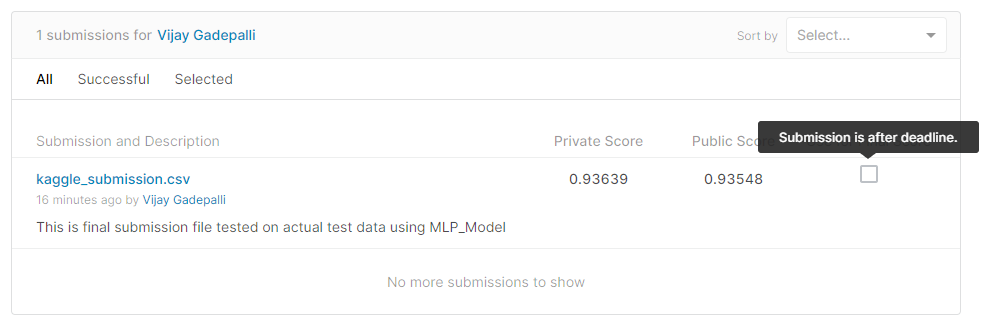